## 2DCNN + BiLSTM model evalutaion

In [1]:
import pandas as pd
import joblib as jbl
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder

### Sampling -> Magnification -> Optical Flow

In [2]:
data_casme = jbl.load("../data/casme_mag_of.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_mag_of.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
labels = pd.read_csv("../data/labels.csv", index_col="Unnamed: 0")
display(labels.head(5))

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


,emotion,AU10,AU64,AU25,AU43,AU24,AU17,AU20,AU7,AU1,...,AU26,AU4,AU63,AU16,AU15,AU6,AU38,AU18,AU39,AU45
0,happiness,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,others,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,others,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,others,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,others,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [3]:
labels["emotion"] = labels["emotion"].apply(lambda x: x.lower())
NUM_EMOTIONS = len(labels["emotion"].unique())
NUM_AUS = len(labels.columns[1:])
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]
le = LabelEncoder()
le.fit(labels["emotion"])
emotions = le.transform(labels["emotion"])
aus = labels[labels.columns[1:]].to_numpy()
DATA_SIZE = concatted.shape[0]

We need to alter the class weights for emotions

In [4]:
emotion_counts = labels["emotion"].value_counts()
display(emotion_counts)
inverse_freq = 1 / emotion_counts.values
inverse_freq = np.ceil(20 * (inverse_freq / np.max(inverse_freq)))
codes = le.transform(emotion_counts.keys())
arg_sorted = np.argsort(codes)
class_weights = inverse_freq[arg_sorted]

emotion
others                 130
negative               127
disgust                 64
surprise                54
positive                34
repression              33
happiness               32
surprise+positive       14
surprise+negative        8
positive+repression      8
sadness                  7
negative+repression      7
surprise+repression      3
fear                     2
Name: count, dtype: int64

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.8)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.8)).prefetch(tf.data.AUTOTUNE)

In [6]:
class_weights = tf.cast(tf.constant(class_weights), dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    weight = tf.gather(class_weights, y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weight

def basic_block(inputs, filter_num, stride=1):
    x = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3, 3), strides=stride, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3, 3), strides=1,padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    shortcut = inputs
    if stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(1, 1), strides=stride)(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def make_blocks(inputs, filter_num, blocks, stride=1):
    x = basic_block(inputs, filter_num, stride=stride)
    for _ in range(1, blocks):
        x = basic_block(x, filter_num, stride=1)
    return x

def frame_encoder(input_shape=None, pooling=None):
    img_input = tf.keras.layers.Input(shape=input_shape)
    
    x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(img_input)
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x) #kernel_initialzer = "he_norm"
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = make_blocks(x, filter_num=64, blocks=1)
    x = make_blocks(x, filter_num=128, blocks=1, stride=2)
    x = make_blocks(x, filter_num=256, blocks=2, stride=2)
    #x = make_block_layers(x, filter_num=512,blocks=2, stride=2)
    if pooling == 'avg':
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
        x = tf.keras.layers.GlobalMaxPooling2D()(x)
    model = tf.keras.Model(img_input, x)
    return model

def build_2d_bilstm(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=12, lstm_hidden=256, dropout_f = 0.2):
    """
    input_shape: (T, H, W, C)
    Uses TimeDistributed 2D encoder, BiLSTM across time, temporal pooling, heads.
    """
    _, H, W, C = input_shape
    video_in = tf.keras.layers.Input(shape=input_shape, name="video_in")  # (T, H, W, C)
    encoder = frame_encoder(input_shape=(H,W,C), pooling="max")
    # TimeDistributed encoder: output shape (batch, T, cnn_feat_dim)
    td = tf.keras.layers.TimeDistributed(encoder, name="td_encoder")(video_in)

    # BiLSTM
    rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_hidden))(td)

    # temporal pooling (mean)
    #pooled = tf.keras.layers.GlobalAveragePooling1D(name="temporal_mean")(rnn)  # (batch, 2*lstm_hidden)
    dense = tf.keras.layers.Dense(lstm_hidden, activation="relu")(rnn)
    dropout = tf.keras.layers.Dropout(dropout_f)(dense)
    emotion_logits = tf.keras.layers.Dense(num_emotions, name="emotion_logits", activation="softmax")(dropout)
    au_logits = tf.keras.layers.Dense(num_aus, name="au_logits", activation="sigmoid")(dropout)

    model = tf.keras.Model(inputs=video_in, outputs=[emotion_logits, au_logits], name="2D_BiLSTM") # au_logits]
    return model

Model: "2D_BiLSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 7, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 td_encoder (TimeDistributed)   (None, 7, 256)       2418944     ['video_in[0][0]']               
                                                                                                  
 bidirectional (Bidirectional)  (None, 256)          394240      ['td_encoder[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 128)          32896       ['bidirectional[0][0]']  

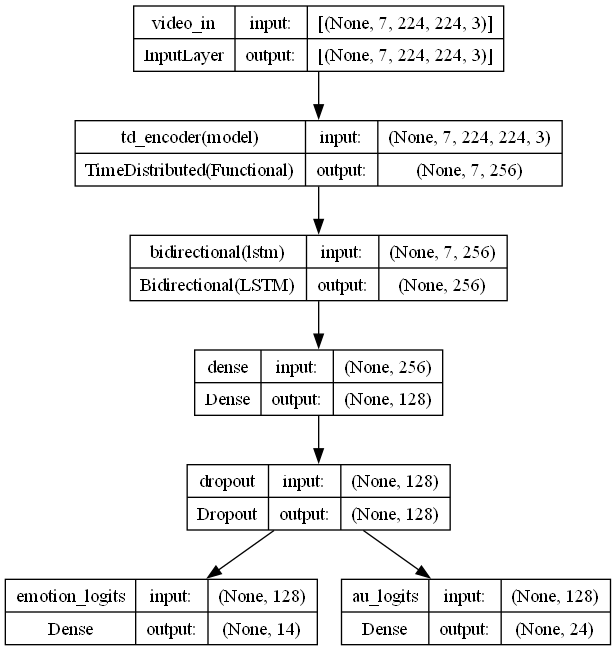

In [7]:
model = build_2d_bilstm(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS, lstm_hidden=128)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True,expand_nested=False)

In [8]:
EPOCHS = 20
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.BinaryAccuracy()
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)
model.save("mag_of.h5")

Epoch 1/20
418/418 [==============================] - 33s 47ms/step - loss: 5.1863 - emotion_logits_loss: 4.2474 - au_logits_loss: 0.4695 - emotion_logits_sparse_categorical_accuracy: 0.1699 - au_logits_binary_accuracy: 0.8497 - val_loss: 4.7701 - val_emotion_logits_loss: 4.1407 - val_au_logits_loss: 0.3147 - val_emotion_logits_sparse_categorical_accuracy: 0.2000 - val_au_logits_binary_accuracy: 0.9155
Epoch 2/20
418/418 [==============================] - 16s 38ms/step - loss: 4.8673 - emotion_logits_loss: 4.3220 - au_logits_loss: 0.2726 - emotion_logits_sparse_categorical_accuracy: 0.1962 - au_logits_binary_accuracy: 0.9240 - val_loss: 3.9195 - val_emotion_logits_loss: 3.4628 - val_au_logits_loss: 0.2283 - val_emotion_logits_sparse_categorical_accuracy: 0.2476 - val_au_logits_binary_accuracy: 0.9306
Epoch 3/20
418/418 [==============================] - 16s 38ms/step - loss: 4.6753 - emotion_logits_loss: 4.2189 - au_logits_loss: 0.2282 - emotion_logits_sparse_categorical_accuracy: 0.17

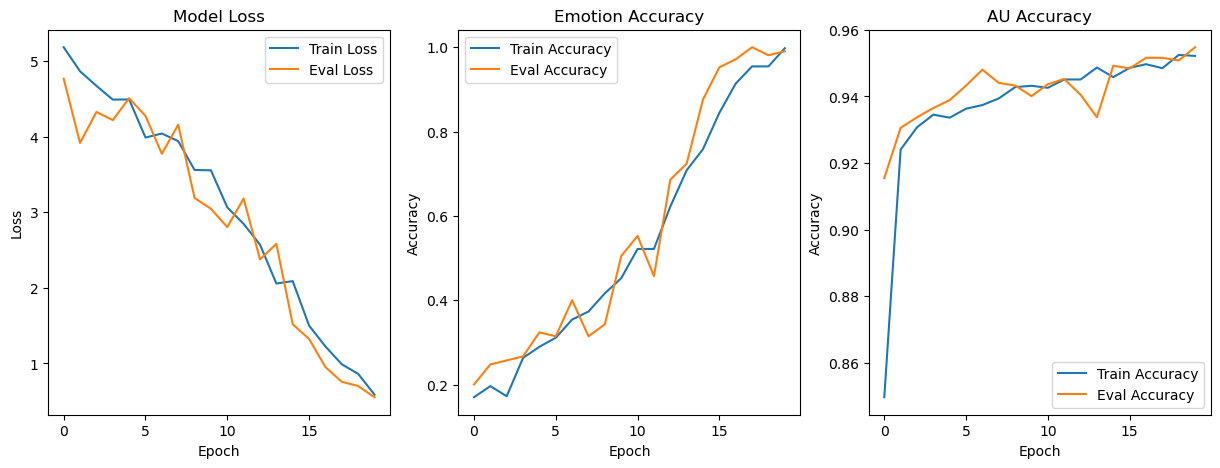

In [9]:
import matplotlib.pyplot as plt

EPOCHS = 20
def results(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    emotion_train_accuracy = history.history['emotion_logits_sparse_categorical_accuracy']
    emotion_val_accuracy =  history.history['val_emotion_logits_sparse_categorical_accuracy']
    au_train_accuracy =  history.history['au_logits_binary_accuracy']
    au_val_accuracy =  history.history['val_au_logits_binary_accuracy']

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(EPOCHS)
        plt.subplot(1, 3, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(emotion_train_accuracy, emotion_val_accuracy, "Accuracy", 2, "Emotion Accuracy")
    plot_history(au_train_accuracy, au_val_accuracy, "Accuracy", 3, "AU Accuracy")
    plt.show()

results(history)

## Sample -> Optical Flow

In [10]:
data_casme = jbl.load("../data/casme_optical_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_optical_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.8)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.8)).prefetch(tf.data.AUTOTUNE)

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


In [ ]:
model = build_2d_bilstm(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS, lstm_hidden=128)
EPOCHS = 20
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.BinaryAccuracy()
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)
model.save("flow.h5")

Epoch 1/20
418/418 [==============================] - 26s 46ms/step - loss: 5.2826 - emotion_logits_loss: 4.3486 - au_logits_loss: 0.4670 - emotion_logits_sparse_categorical_accuracy: 0.2010 - au_logits_binary_accuracy: 0.8229 - val_loss: 4.8666 - val_emotion_logits_loss: 4.2688 - val_au_logits_loss: 0.2989 - val_emotion_logits_sparse_categorical_accuracy: 0.2286 - val_au_logits_binary_accuracy: 0.9385
Epoch 2/20
418/418 [==============================] - 17s 40ms/step - loss: 4.6744 - emotion_logits_loss: 4.1547 - au_logits_loss: 0.2598 - emotion_logits_sparse_categorical_accuracy: 0.2679 - au_logits_binary_accuracy: 0.9336 - val_loss: 4.1366 - val_emotion_logits_loss: 3.6898 - val_au_logits_loss: 0.2234 - val_emotion_logits_sparse_categorical_accuracy: 0.3143 - val_au_logits_binary_accuracy: 0.9357
Epoch 3/20
418/418 [==============================] - 16s 39ms/step - loss: 4.1456 - emotion_logits_loss: 3.7143 - au_logits_loss: 0.2157 - emotion_logits_sparse_categorical_accuracy: 0.27

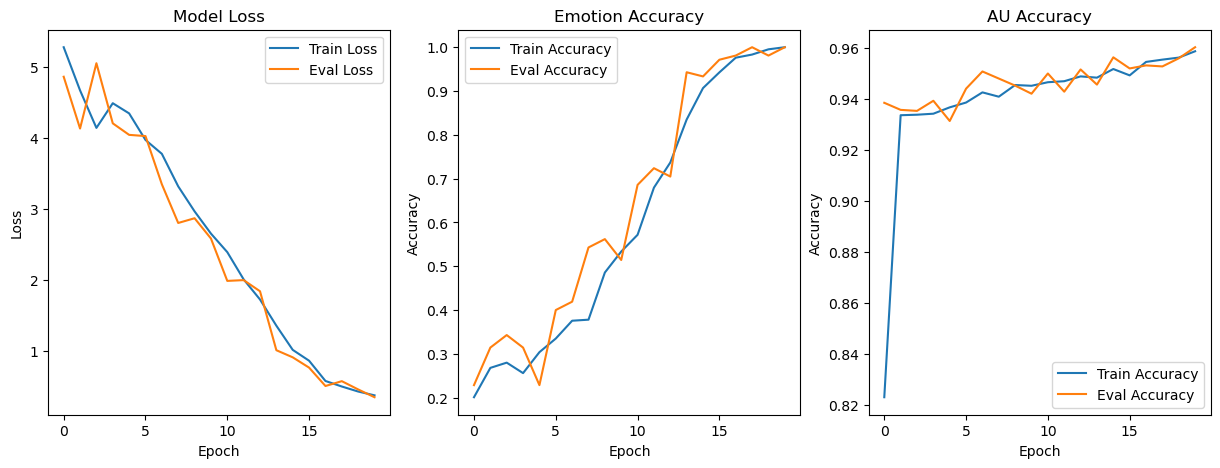

In [12]:
results(history)

## Magnification -> Sample

In [13]:
data_casme = jbl.load("../data/casme_magnify_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_magnify_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.8)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.8)).prefetch(tf.data.AUTOTUNE)

(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 8, 224, 224)


Epoch 1/20
418/418 [==============================] - 25s 43ms/step - loss: 4.8111 - emotion_logits_loss: 3.9897 - au_logits_loss: 0.4107 - emotion_logits_sparse_categorical_accuracy: 0.2919 - au_logits_binary_accuracy: 0.8562 - val_loss: 3.9883 - val_emotion_logits_loss: 3.4099 - val_au_logits_loss: 0.2892 - val_emotion_logits_sparse_categorical_accuracy: 0.4381 - val_au_logits_binary_accuracy: 0.9345
Epoch 2/20
418/418 [==============================] - 16s 38ms/step - loss: 4.4114 - emotion_logits_loss: 3.8825 - au_logits_loss: 0.2645 - emotion_logits_sparse_categorical_accuracy: 0.3349 - au_logits_binary_accuracy: 0.9311 - val_loss: 3.7075 - val_emotion_logits_loss: 3.2266 - val_au_logits_loss: 0.2405 - val_emotion_logits_sparse_categorical_accuracy: 0.3429 - val_au_logits_binary_accuracy: 0.9306
Epoch 3/20
418/418 [==============================] - 16s 38ms/step - loss: 4.1872 - emotion_logits_loss: 3.7309 - au_logits_loss: 0.2282 - emotion_logits_sparse_categorical_accuracy: 0.39

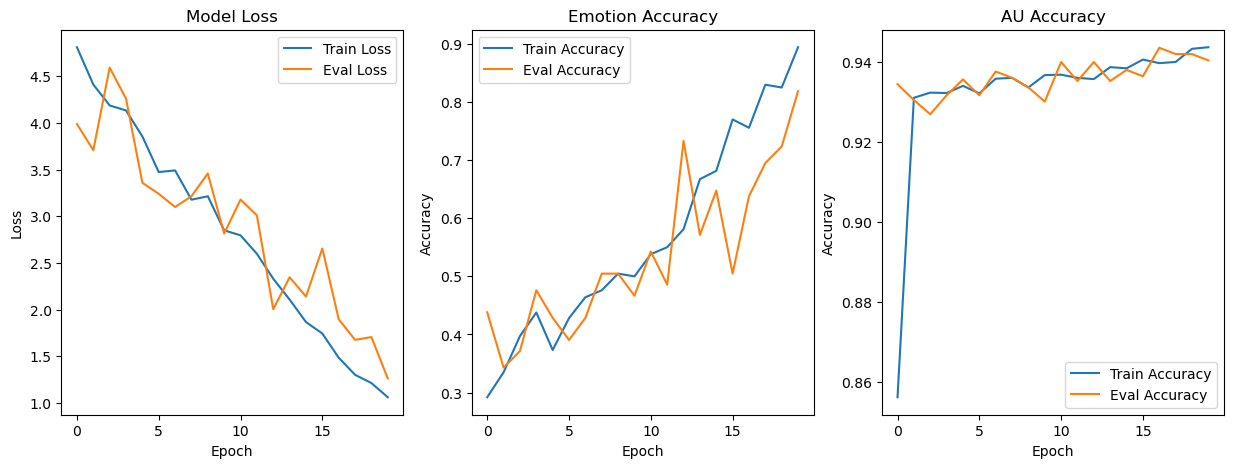

In [14]:
model = build_2d_bilstm(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS, lstm_hidden=128)
EPOCHS = 20
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.BinaryAccuracy()
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)
results(history)
model.save("magnify.h5")